# SOCIB Modelling and Forecasting Facility - MFF Python Library Tutorials
## Calculating FSLE (Finity-Size Lyapunov Exponent)
### Using [OceanParcels](https://oceanparcels.org) to simulate the particles necessary to calculate the FSLE.
---

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../../')

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### **Importing the MFF modules**

In [3]:
from socib_modelling_python.batch import SimulationFactory
from socib_modelling_python.compute import lagrangian as mff_lagrangian
from socib_modelling_python.plot.mff_maps import plot_points_map
from socib_modelling_python.batch.generate_particles import GenerateParticles

INFO: Compiled ParcelsRandom ==> /tmp/parcels-19211/libparcels_random_61760707-ef46-48bc-9a31-1b662acc387c.so


In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from scipy.interpolate import NearestNDInterpolator

In [5]:
import cartopy
import cartopy.feature as cfeature

land_map = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

In [6]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.geodesic as geodesic
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [7]:
from socib_modelling_python.config import Config as MFF_Config
_MFF_CONFIG = MFF_Config()

#### **Loading some data**

In [7]:
data = xr.open_dataset("/LOCALDATA/Alex/sandbox/wmop_surface_thredds.nc", chunks='auto')

<Figure size 432x288 with 0 Axes>

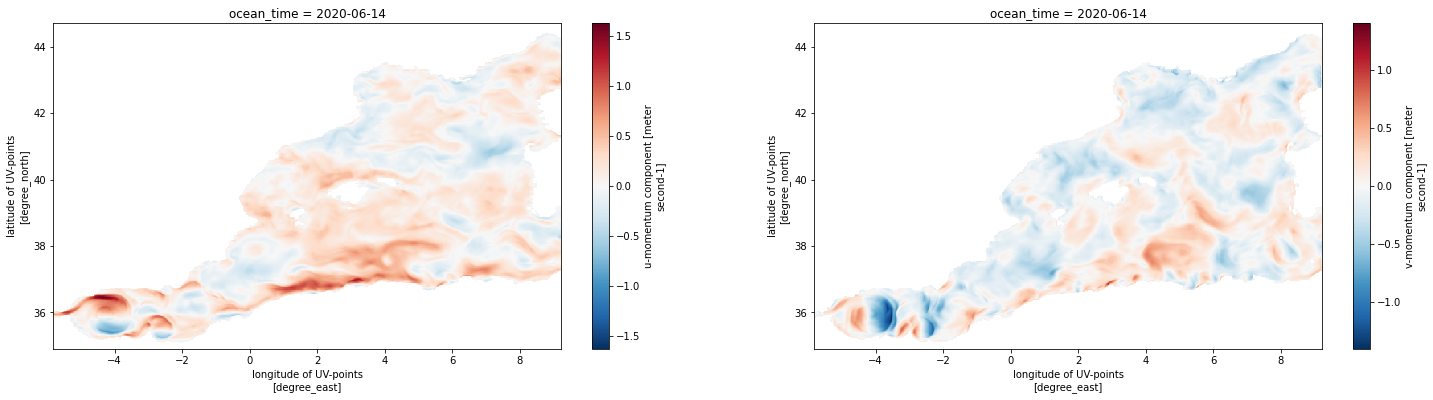

In [8]:
fig = plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.sca(axes[0])
data.isel(ocean_time=0).squeeze().u.plot()
plt.sca(axes[1])
data.isel(ocean_time=0).squeeze().v.plot()
plt.show()

#### **Generating particles on grid points**

setting a land_mask

In [9]:
da = data['u'].isel(ocean_time=0)
land = np.isnan(da)
data['land_mask'] = land

land_coords = {
    'latitude': 'lat_uv',
    'longitude': 'lon_uv'
}

#### **Setting-up the simulator**
we first define a list of kernels in the order to be executed, for that examples we used only the Advection (2D) kernel.  
Then we initizalize our simulator passing a list of particles and other parameters.  
For this exemple, we activated the periodic boundary strategy for 'DeleteParticles'.  

For FSLE experiments it is necessary to use the particles class (pclass) JITParticleAssociated.  
That class saves the index of N-partciles associated with the a specific particle.  
In that tutorial, we created the particles with a 4NN2D strategy, which means that we save the index of the four grid points in the neighbourhood of a particle.  
That information is provide for the simulation thru the parameter "pclass_config" > "n_associations" == 4

In [10]:
 specs = {
    "kind": "parcels",
    "fieldset": {
        "params": {
            "field": data,
            "variables": {"U": "u", "V": "v"},
            "dimensions": {"time": "ocean_time",
                           "lat": "lat_uv", "lon": "lon_uv"},
        }
    },
    "particles": {
        "generator": {
            "method": "associated_particles",
            "params": {
                "grid": data,
                "latitude": 'lat_uv',
                "longitude": 'lon_uv',
                "land_mask": data["land_mask"],
                "land_mask_coords": land_coords,
                "region": "BalearicIslands",
                "strategy": "4NN2D"
            }
        },
        "pclass": "JITParticleAssociated",
        "pclass_config": {
            "n_associations": 4,
            "associated": True
        }
    },
    "kernels": {
        "sequence": ["AdvectionRK4"]
    },
    "strategies": {
        "boundaries": "DeleteParticle"
    },
    "execution": {
        "dt": {"hours": 3},
        "outputdt": {"days": 1},
        "runtime": {"days": 200}
    }
}

#### **Building the simulator with the configuration dictionary and the information about Particles Association.**  

In [11]:
simulation = SimulationFactory.produce(specs)
generated_particles = simulation.get_all_particles_location()

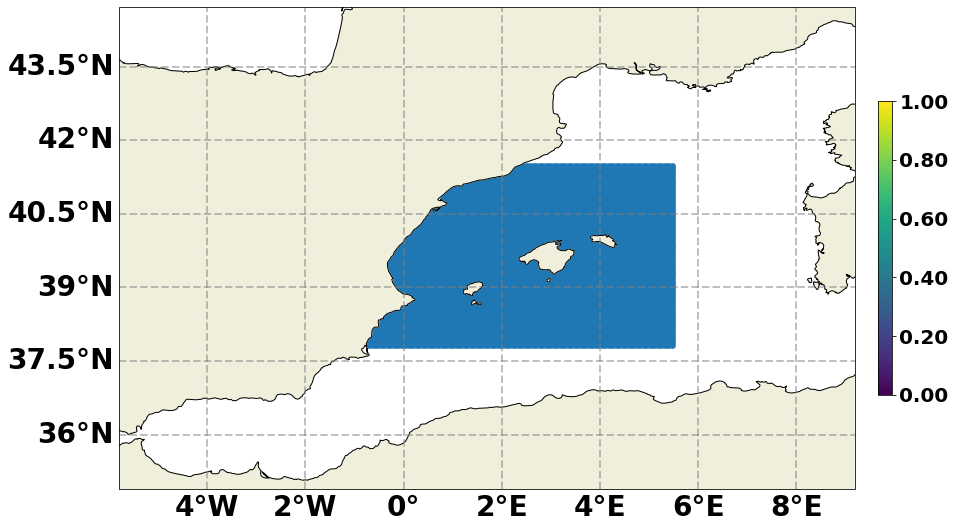

In [12]:
plot_points_map(generated_particles[1], generated_particles[0], show=True, region='WesternMed', kind='scatter', marker_size=10)

#### **Running the simulation**
The method "run" accepts a file location where the output will be written.  
Otherwise, a temporary file will be create and the file location is the return value of "run".

In [13]:
output_file = simulation.run(output_filename="/tmp/tutorial_calculate_fsle_with_parcels.nc")

100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:00:41 Time:  0:00:41


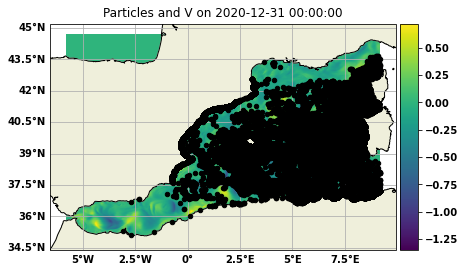

In [14]:
simulation.particle_set.show(field=simulation.field.V, land='10m', cartopy_features=[land_map])

### Calculating FSLE with the simulation output

In [15]:
output_file = "/tmp/tutorial_calculate_fsle_with_parcels.nc"

In [16]:
simulation_result = xr.open_dataset(output_file)

In [17]:
fsle_result = mff_lagrangian.calculate_FSLE(output_file, delta_i=2_000, delta_f=40_000, delta_t=1, aggregation="max")

100%|██████████| 43009/43009 [00:12<00:00, 3549.09it/s]


In [20]:
fsle_grid = np.ones((data.dims['lat_uv'], data.dims['lon_uv'])) * np.nan

In [21]:
for pi, pj, v in zip(generated_particles[0], generated_particles[1], fsle_result):
    idx_lon = (np.abs(data.lon_uv.values - pj)).argmin()
    idx_lat = (np.abs(data.lat_uv.values - pi)).argmin()
    fsle_grid[idx_lat, idx_lon] = v

In [22]:
region='BalearicIslands'
cfg = _MFF_CONFIG.get('regions')[region]

In [23]:
ones = np.ones((data.dims['lat_uv'], data.dims['lon_uv']))

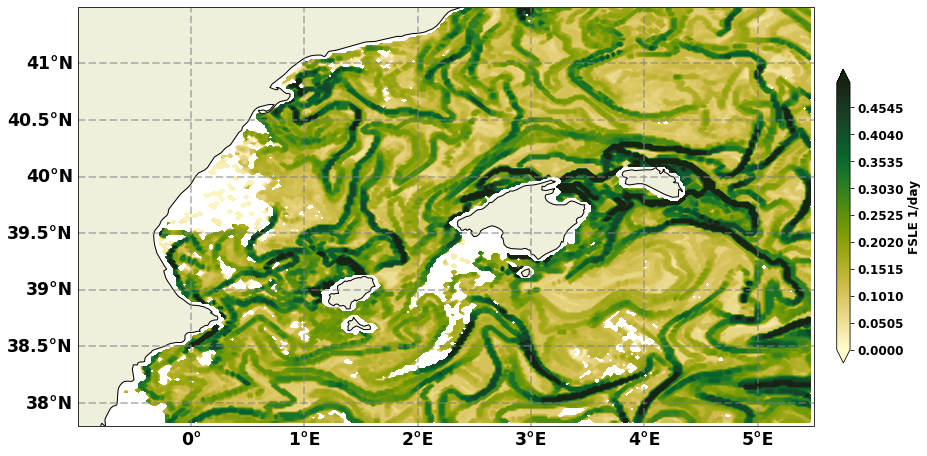

In [24]:
map_min_lon, map_max_lon, map_min_lat, map_max_lat = cfg['area']
fig = plt.figure(**cfg['figure'])
ax = plt.axes(projection=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
ax.add_feature(land)
ax.coastlines(resolution='10m')
ax.set_extent([map_min_lon, map_max_lon, map_min_lat, map_max_lat], crs=ccrs.PlateCarree())

vmin = 0.0
vmax = 0.5

levels = np.linspace(vmin, vmax, 100)

cs = plt.contourf(data.lon_uv.values, data.lat_uv.values, fsle_grid,
                  vmin=vmin, vmax=vmax, levels=levels, extend='both', cmap=cmocean.cm.speed)

cb = plt.colorbar(cs, orientation='vertical', pad=0.025, shrink=0.6)
cb.set_label("FSLE 1/day", size='large', weight='bold')
cb.ax.tick_params(labelsize='large')

# gridlines formatting
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
if 'xgridlines' in cfg:
    gl.xlocator = mticker.FixedLocator(cfg['xgridlines'])
if 'ygridlines' in cfg:
    gl.ylocator = mticker.FixedLocator(cfg['ygridlines'])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}

plt.show()

### **Running a FSLE with Custom Particles**

In the following examples we will show how to use custom partciles and FSLE

In [8]:
data = xr.open_dataset("/LOCALDATA/Alex/sandbox/wmop_surface_thredds.nc", chunks='auto')

#### **Defining a land mask**

In [9]:
da = data['u'].isel(ocean_time=0)
land = np.isnan(da)
data['land_mask'] = land

land_coords = {
    'latitude': 'lat_uv',
    'longitude': 'lon_uv'
}

In [10]:
lats, lons, depths, associations = GenerateParticles.associated_particles(data, latitude='lat_uv', longitude='lon_uv',
                                                                          region='MallorcaChannel', land_mask=data.land_mask, land_mask_coords=land_coords)

#### **Reading a bathymetry and setting-up a origin value**

In [11]:
grid = xr.open_dataset("../../socib_modelling_python/tests/batch/data/bathymetry_WMOPv2.0.nc", cache=False)

In [12]:
Hbath = NearestNDInterpolator((grid.lon_rho.values.flatten(), grid.lat_rho.values.flatten()), grid.h.values.flatten())

In [13]:
particles_bathy = Hbath(lons, lats)

In [14]:
origin = (particles_bathy <= 200)

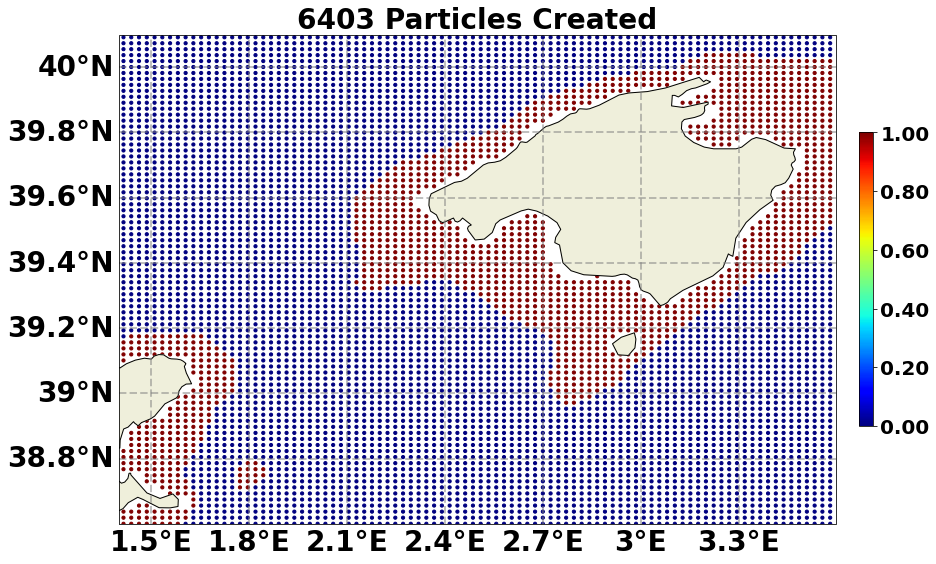

In [15]:
plot_points_map(lons, lats, hue=origin, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(lats)} Particles Created')

#### **Setting-up the simulator**
In this example, we will use the generator type "from_list" because we already have generated our particles.  
This method will receive our three custom lists resulted from the concatenation of the two types of particles.  

We will also use a new type of particle implemented inside of the file *./extras/custom_particles_with_origin.py*.  
Inside this file, the Class *JITParticleWithOrigin* defines a particle type based on the *JITParticle* class.  
*JITParticleWithOrigin* has a new attribute called *origin* that will save (only once) the information about the particles' starting point.  

To use this new class, we first define a custom_particles_path inside our specification.  
Based on this path, the particles factory will be able to create our custom particle.   

Now, we need to initialize the particles' attribute "origin" with the correct values.  
Thus, we pass our origin vector as a parameter of our particles' specification.  

As a result, the simulation output file will have a new variable containing the origin information.  
Also, if it is necessary, the origin variable can be used inside a custom kernel for example.    

In [16]:
specs = {
    "kind": "parcels",
    "fieldset": {
        "params": {
            "field": data,
            "variables": {"U": "u", "V": "v"},
            "dimensions": {"time": "ocean_time",
                           "lat": "lat_uv", "lon": "lon_uv"},
        }
    },
    "particles": {
        "custom_particles_path": "./extras/custom_particles_with_origin.py",
        "generator": {
            "method": "from_list",
            "params": {
                "latitudes": lats,
                "longitudes": lons,
                "depth": depths,
                "associations": associations
            }
        },
        "pclass": "JITParticleWithOrigin",
        "pclass_config": {
            "n_associations": 4,
            "associated": True
        },
        "params": {
            "origin": origin
        }
    },
    "kernels": {
        "sequence": ["AdvectionRK4"]
    },
    "strategies": {
        "boundaries": "DeleteParticle"
    },
    "execution": {
        "dt": {"hours": 3},
        "outputdt": {"days": 1},
        "runtime": {"days": 200}
    }
}

In [17]:
simulation = SimulationFactory.produce(specs)
generated_particles = simulation.get_all_particles_location()

#### **Running the simulation**

In [18]:
output_file = simulation.run(output_filename="/tmp/tutorial_lagrangian_simulation_parcels.nc")

100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:00:14 Time:  0:00:14


#### **Openning the output file and plotting the final position with the color indicating the particles' origin**

In [19]:
ds = xr.open_dataset(output_file, cache=False)

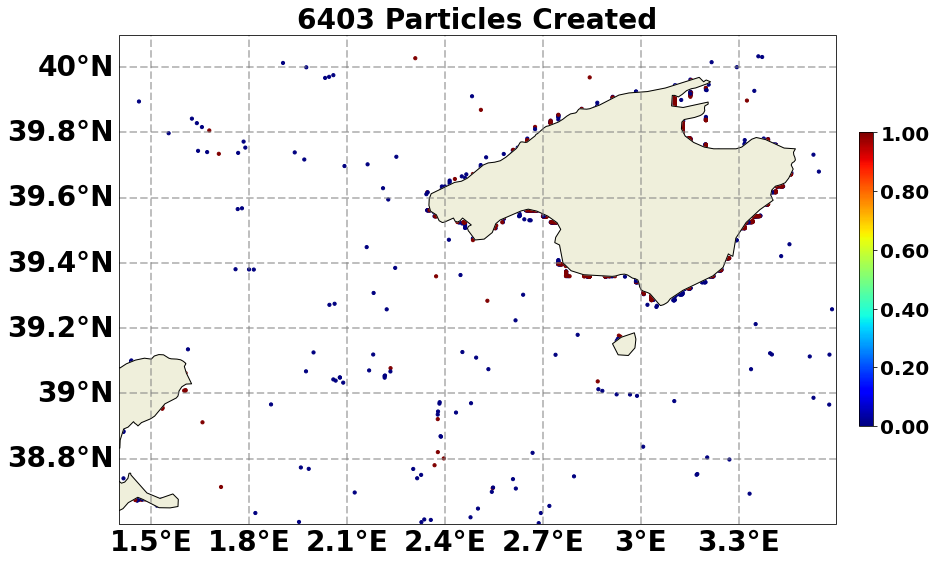

In [20]:
plats = ds.lat.isel(obs=-1).values
plons = ds.lon.isel(obs=-1).values
porigin = ds.origin.values
plot_points_map(plons, plats, hue=porigin, show=True, region='MallorcaChannel', kind='scatter', marker_size=10, title=F'{len(plats)} Particles Created')

In [21]:
fsle_result = mff_lagrangian.calculate_FSLE(output_file, delta_i=2_000, delta_f=40_000, delta_t=1, aggregation="max")

100%|██████████| 6403/6403 [00:08<00:00, 748.04it/s]


In [22]:
fsle_grid = np.ones((data.dims['lat_uv'], data.dims['lon_uv'])) * np.nan

In [23]:
for pi, pj, v in zip(generated_particles[0], generated_particles[1], fsle_result):
    idx_lon = (np.abs(data.lon_uv.values - pj)).argmin()
    idx_lat = (np.abs(data.lat_uv.values - pi)).argmin()
    fsle_grid[idx_lat, idx_lon] = v

In [24]:
region='MallorcaChannel'
cfg = _MFF_CONFIG.get('regions')[region]

In [26]:
ones = np.ones((data.dims['lat_uv'], data.dims['lon_uv']))

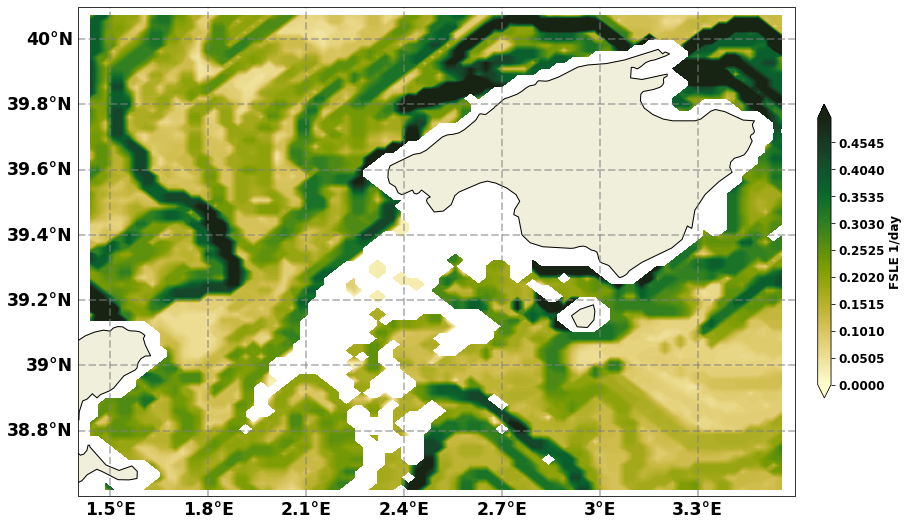

In [27]:
map_min_lon, map_max_lon, map_min_lat, map_max_lat = cfg['area']
fig = plt.figure(**cfg['figure'])
ax = plt.axes(projection=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
ax.add_feature(land)
ax.coastlines(resolution='10m')
ax.set_extent([map_min_lon, map_max_lon, map_min_lat, map_max_lat], crs=ccrs.PlateCarree())

vmin = 0.0
vmax = 0.5

levels = np.linspace(vmin, vmax, 100)

cs = plt.contourf(data.lon_uv.values, data.lat_uv.values, fsle_grid,
                  vmin=vmin, vmax=vmax, levels=levels, extend='both', cmap=cmocean.cm.speed)

cb = plt.colorbar(cs, orientation='vertical', pad=0.025, shrink=0.6)
cb.set_label("FSLE 1/day", size='large', weight='bold')
cb.ax.tick_params(labelsize='large')

# gridlines formatting
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
if 'xgridlines' in cfg:
    gl.xlocator = mticker.FixedLocator(cfg['xgridlines'])
if 'ygridlines' in cfg:
    gl.ylocator = mticker.FixedLocator(cfg['ygridlines'])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}

plt.show()

---
---
---
---
---
---
---
---
---
---